# Praktikum 1 - RNN untuk Analisis Sentimen

**Setup**

In [17]:
import numpy as np #operasi numerik
import tensorflow as tf #latih jaringan saraf
import tensorflow_datasets as tfds #tfds merupakan Tensorflow Datasets yang meneydiakan akses untuk kumpulan dataset yang digunakan dalam Ml
tfds.disable_progress_bar() #untuk nonaktifkan bar kemajuan yang biasanya ditampilkan saat mengunduh dataset dengan TensorFlow Datasets

In [18]:
import matplotlib.pyplot as plt #membuat grafik dan visualisasi

def plot_graphs(history, metric):#definisiakn fungsi plot_graphs untuk buat rafik 
  plt.plot(history.history[metric]) #buat grafik untuk perubahan metrik saat pelatihan dari objek history 
  plt.plot(history.history['val_'+metric], '') #Buat grafik metrik validasi 
  plt.xlabel("Epochs")#memberi label pada sumbu x 
  plt.ylabel(metric)#memberi label pada sumbu y
  plt.legend([metric, 'val_'+metric])#menambhakan teks penjelasan bahwa garis pertama sesuai dengan metric dan garis kedua putus-putus mewakili matrik validasi 

**Setup Input pipeline**

In [19]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)#unduh dataset dan meminta info tambahan
train_dataset, test_dataset = dataset['train'], dataset['test']#bagi datset jadi 2 yaitu data latih dan data test

train_dataset.element_spec #get info struktur elemen data latih

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [20]:
for example, label in train_dataset.take(1):#ambil 1 elemen pada dataset
  print('text: ', example.numpy())#cetak teks, ambul nilai dari tensor yang berisi ulasa 
  print('label: ', label.numpy())#cetak nilai label dari tensor

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [21]:
#prose dg tensorflow
BUFFER_SIZE = 10000#mendefinisikan ukuran buffer yang digunakan untuk mengacak data dalam datsest
BATCH_SIZE = 64#mendefinisikan ukuran batch yang akan digunakan saat melatih model


#proses pelatihan dan test
# elemn diacak dulu (shuffle(BUFFER_SIZE)), 
# dijadikan batch (batch(BATCH_SIZE)), 
# dan (prefetch(tf.data.AUTOTUNE))untuk mengoptimalkan pembacaan data dengan prefetching dan untuk memuat data lebih cepat saat model melatih. 
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):#loop untuk meambil 1 batch untuk contoh
  print('texts: ', example.numpy()[:3])#cetak 3 ulasan
  print()
  print('labels: ', label.numpy()[:3])# cetak label dari ulasan


texts:  [b'First of all, write the script on a napkin. Who needs more than that? After all we\'re not a Hollywood film.<br /><br />Then get amateur actors. It will be good for the festival hype. After all, who needs people who have spent years honing their craft? Then, hire a cinematographer who doesn\'t know how to light. You see, if it\'s well-lit, it won\'t look "real" and the festival people won\'t like it. Who needs to have professional level photography anyway? Then hire a ten-year old who has never held a camera to be your operator. It will give your movie that completely amateurish touch that festival screeners will mistake for "reality" and guarantee that even though you will empty the seats from real people, critics and a small sliver of the audience who over-intellectualize will scream "genius" because they won\'t believe this was just complete amateur-hour.<br /><br />Once you\'ve done that, buy your ticket to the Festival of Bad Movies aka Sundance.<br /><br />What a sad w

**Buat Teks Encoder**

In [22]:
VOCAB_SIZE = 1000#definisikan ukuran kosakata yg akan digunakan saat prose s teks 

#buat objek encoder yang merupak layer dari TextVectorization
#untuk ubah teks jadi numrik dengan panjang yang sama untuk semua teks
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))#proses adaptasi untuk membangun kosakta berdasarkan data latih 

In [23]:
  #encoder.get_vocabulary() untuk mendapatkan kosakata yang telah dibangun oleh layer TextVectorization
  #kemudian mengonversinya menjadi array numpy
  vocab=np.array(encoder.get_vocabulary())
  vocab[:20]#cetak 20 ata peratam dalam kosakata

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [24]:
encoded_example = encoder(example)[:3].numpy()#ubah teks jadi numerik dgn ambil 3 contoh pertama dalam batch itu
encoded_example

array([[ 86,   5,  32, ...,   0,   0,   0],
       [ 29,   5,   1, ...,   0,   0,   0],
       [  1, 442,   7, ...,   0,   0,   0]])

In [25]:
for n in range(3):#loop untuk 3 contoh teks 
  print("Original: ", example[n].numpy())#cetak teks asli
  
  #cetak teks yang telah dikodekan kembali ke dalam bahasa manusia. 
  # encoded_example[n] untuk mendapatkan representasi vektor numerik yang telah dihasilkan sebelumnya dan kemudian mengonversinya ke dalam bentuk teks menggunakan kosakata vocab. 
  # Fungsi " ".join() digunakan untuk menggabungkan kata-kata dalam representasi vektor numerik ke dalam satu string dengan spasi sebagai pemisah
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'First of all, write the script on a napkin. Who needs more than that? After all we\'re not a Hollywood film.<br /><br />Then get amateur actors. It will be good for the festival hype. After all, who needs people who have spent years honing their craft? Then, hire a cinematographer who doesn\'t know how to light. You see, if it\'s well-lit, it won\'t look "real" and the festival people won\'t like it. Who needs to have professional level photography anyway? Then hire a ten-year old who has never held a camera to be your operator. It will give your movie that completely amateurish touch that festival screeners will mistake for "reality" and guarantee that even though you will empty the seats from real people, critics and a small sliver of the audience who over-intellectualize will scream "genius" because they won\'t believe this was just complete amateur-hour.<br /><br />Once you\'ve done that, buy your ticket to the Festival of Bad Movies aka Sundance.<br /><br />What a sad

**Buat Model**

In [26]:
#mendefinisiak model dalam tensorflow pakai tf.keras.Sequential
model = tf.keras.Sequential([
    encoder, #layer pertama untuk ubah teks input jadi numerik
    tf.keras.layers.Embedding(#ganti kata2 dalam numerik dg vektor embedding yg dipelajari model 
        input_dim=len(encoder.get_vocabulary()),#atur panjang kosa kata
        output_dim=64,#dimensi vektor embedding
        # Use masking to handle the variable sequence lengths
        mask_zero=True),#aktifin mask untuk panjang urutan variabel 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),#layer rekursif untuk memproses urutan teks dalam kedua arah, yaitu maju dan mundur.  
    tf.keras.layers.Dense(64, activation='relu'),#layer dense (lapisan penuh) dengan 64 unit dan aktivasi ReLU (Rectified Linear Unit). Layer ini digunakan untuk memproses fitur-fitur yang dihasilkan oleh LSTM sebelumnya.
    tf.keras.layers.Dense(1)#layer dense dengan satu unit, yang digunakan sebagai output layer.
])

In [27]:
#cetak apakah setiap lapisan (layer) dalam model mendukung masking atau tidak
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


***Keterangan***

Berati lapisan pertama tidak mendukung masking, 4 lapisan berikutnya mendukung maskin

In [28]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')#conoth sampelnya 
predictions = model.predict(np.array([sample_text]))#melakukan prediksi pada teks sample yang awalnya harus dikonversi dulu ke array numpy
print(predictions[0])#cetak hasil prediksi 

1/1 [==============================] - 4s 4s/step
[0.01301279]


In [29]:
# predict on a sample text with padding

padding = "the " * 2000#mengulang kata "the" sebanyak 2000 kali untuk menambahkan teks yang sangat panjang ke dalam model
predictions = model.predict(np.array([sample_text, padding]))#melakukan prediksi pada sample teks, dan padding (the 200 kali)
print(predictions[0])#cetak prediksi sentimen

1/1 [==============================] - 0s 254ms/step
[0.01301279]


In [30]:
#compile model
#menggunakan BinaryCrossentropy untuk konfigurasu loss function 
#from_logits=True menunjukkan bahwa output model dalam bentuk "logit" atau "score" 
#menggunakan metrik accuracy untuk pantau prediksi model 
#optimizer=tf.keras.optimizers.Adam(1e-4): Ini adalah konfigurasi optimizer (pengoptimal) yang digunakan selama pelatihan model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**Train Model**

In [31]:
#latih model 
#jumlah iterasi melatih model(epoch)=10 
#validation_data=test_dataset:data validasi yang digunakan untuk mengukur kinerja model selama pelatihan. Data ini berisi teks ulasan dan labelnya.
#validation_steps=30:jumlah langkah validasi yang akan diambil selama setiap epoch
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset,
validation_steps=30)

Epoch 1/10
391/391 [==============================] - 600s 2s/step - loss: 0.6568 - accuracy: 0.5477 - val_loss: 0.5167 - val_accuracy: 0.7182
Epoch 2/10
391/391 [==============================] - 565s 1s/step - loss: 0.4432 - accuracy: 0.7842 - val_loss: 0.4163 - val_accuracy: 0.8250
Epoch 3/10
391/391 [==============================] - 565s 1s/step - loss: 0.3648 - accuracy: 0.8371 - val_loss: 0.3548 - val_accuracy: 0.8391
Epoch 4/10
391/391 [==============================] - 569s 1s/step - loss: 0.3313 - accuracy: 0.8576 - val_loss: 0.3305 - val_accuracy: 0.8583
Epoch 5/10
391/391 [==============================] - 563s 1s/step - loss: 0.3218 - accuracy: 0.8607 - val_loss: 0.3357 - val_accuracy: 0.8635
Epoch 6/10
391/391 [==============================] - 570s 1s/step - loss: 0.3116 - accuracy: 0.8672 - val_loss: 0.3212 - val_accuracy: 0.8646
Epoch 7/10
391/391 [==============================] - 566s 1s/step - loss: 0.3063 - accuracy: 0.8691 - val_loss: 0.3378 - val_accuracy: 0.8672

In [39]:
#test_loss: nilai loss / kerugian untuk ukur sejauh mana prediksi model mendekati label benar 
#test_acc: aurasu pada dat uji, akurasi ukur sejauh mana model benar dalam meprediksi kelas dari data pengujian
test_loss, test_acc = model.evaluate(test_dataset)#evaluasi 

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 264s 673ms/step - loss: 0.3665 - accuracy: 0.8430
Test Loss: 0.36649417877197266
Test Accuracy: 0.842960000038147


(0.0, 0.6747821509838104)

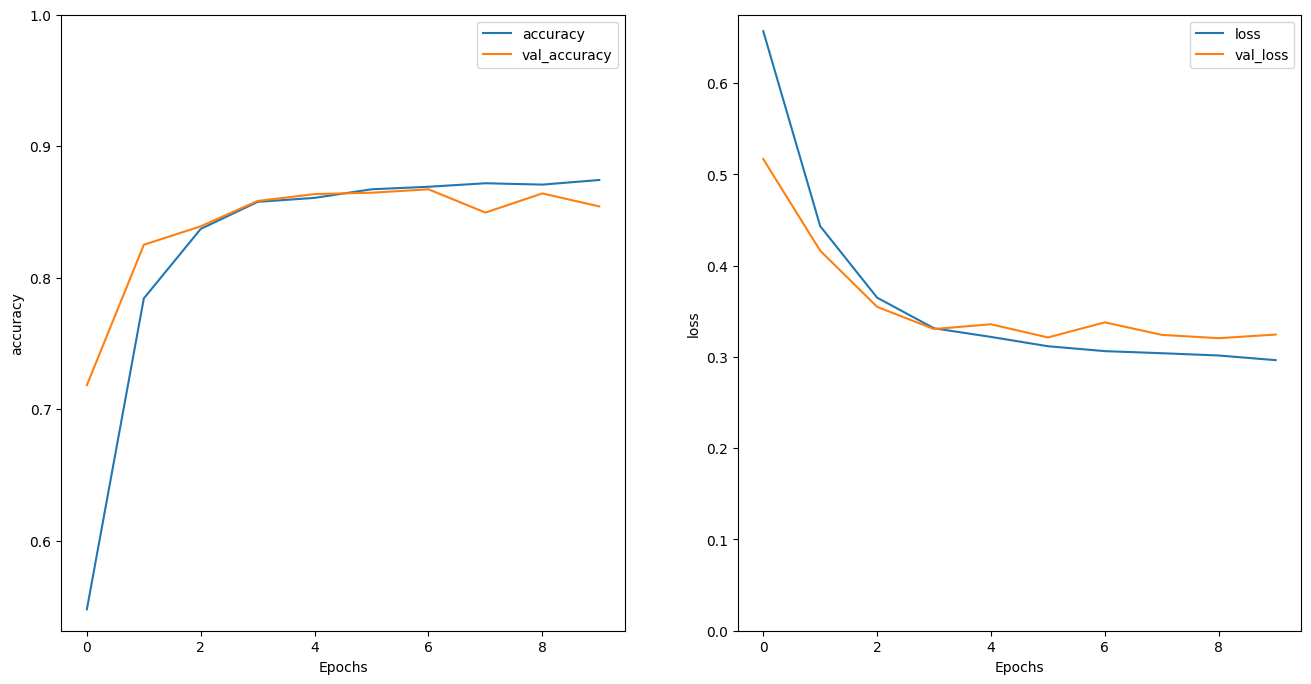

In [40]:
#buat grafik akurasi dan loss 
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

***Keterangan***

Nilai accuracy semakin naik seiring dengan beerjalannya epoch, sedangkan nilai loss / kerugian terus berkurang seiring berjalannya epoch 


1. Accuracy : akurasi model pada data pelatihan selama berjalannya epoch. Jika akurasi pelatihan terus meningkat seiring berjalannya epoch, itu menunjukkan bahwa model belajar dengan baik dari data pelatihan.

2. Val Accuracy : akurasi model pada data validasi yang merupakan data yang tidak digunakan dalam pelatihan. Jika akurasi validasi naik bersamaan dengan akurasi pelatihan, itu menunjukkan bahwa model dapat menggeneralisasi dengan baik ke data yang belum pernah dilihat sebelumnya.

3. Loss: Nilai kehilangan model pada data pelatihan seiring berjalannya epoch. Jika nilai loss pelatihan terus menurun seiring dengan peningkatan jumlah epoch, itu menunjukkan bahwa model terus mempelajari data pelatihan.

4. Val Loss: Validation loss adalah nilai kehilangan model pada data validasi yang merupakan data yang tidak digunakan dalam pelatihan. Jika nilai validation loss juga menurun seiring dengan peningkatan epoch, itu menunjukkan bahwa model dapat melakukan generalisasi dengan baik pada data yang belum pernah dilihat sebelumnya.

In [41]:
#prediksi pada kalimat barus 
sample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 7s 7s/step


***Keterangan***

Hasil prediksi "1/1" menunjukkan bahwa model memprediksi teks tersebut sebagai sentimen positif dan prediksinya benar.

**Stack two or more LSTM layers**

In [42]:
#Model memiliki struktur yang kompleks dan banyak parameter, yang membuatnya mampu memahami teks dengan baik
#overfitting diataso dengan mekanisme drop out
model = tf.keras.Sequential([
    encoder,
     tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
     tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dropout(0.5),#layer dropout yang digunakan untuk mencegah overfitting. 
     tf.keras.layers.Dense(1)
])

In [43]:
#prose bompile 
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
 optimizer=tf.keras.optimizers.Adam(1e-4),
 metrics=['accuracy'])

In [44]:
#melatih model dengan iterasi epoch 10
history = model.fit(train_dataset, epochs=10,
 validation_data=test_dataset,
 validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1216s 3s/step - loss: 0.6181 - accuracy: 0.5887 - val_loss: 0.4437 - val_accuracy: 0.7766
Epoch 2/10
391/391 [==============================] - 1191s 3s/step - loss: 0.3731 - accuracy: 0.8346 - val_loss: 0.3416 - val_accuracy: 0.8568
Epoch 3/10
391/391 [==============================] - 1182s 3s/step - loss: 0.3283 - accuracy: 0.8597 - val_loss: 0.3277 - val_accuracy: 0.8448
Epoch 4/10
391/391 [==============================] - 1161s 3s/step - loss: 0.3169 - accuracy: 0.8655 - val_loss: 0.3184 - val_accuracy: 0.8562
Epoch 5/10
391/391 [==============================] - 1146s 3s/step - loss: 0.3124 - accuracy: 0.8669 - val_loss: 0.3251 - val_accuracy: 0.8604
Epoch 6/10
391/391 [==============================] - 1134s 3s/step - loss: 0.3060 - accuracy: 0.8714 - val_loss: 0.3212 - val_accuracy: 0.8635
Epoch 7/10
391/391 [==============================] - 1142s 3s/step - loss: 0.3044 - accuracy: 0.8700 - val_loss: 0.3245 - val_accuracy:

In [45]:
#evaluasi akurasi dan loss pada model 
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 247s 633ms/step - loss: 0.3156 - accuracy: 0.8543
Test Loss: 0.31558364629745483
Test Accuracy: 0.8543199896812439


In [46]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.8778247]]


***Keterangan***

Penilaian model rendah terhadap teks

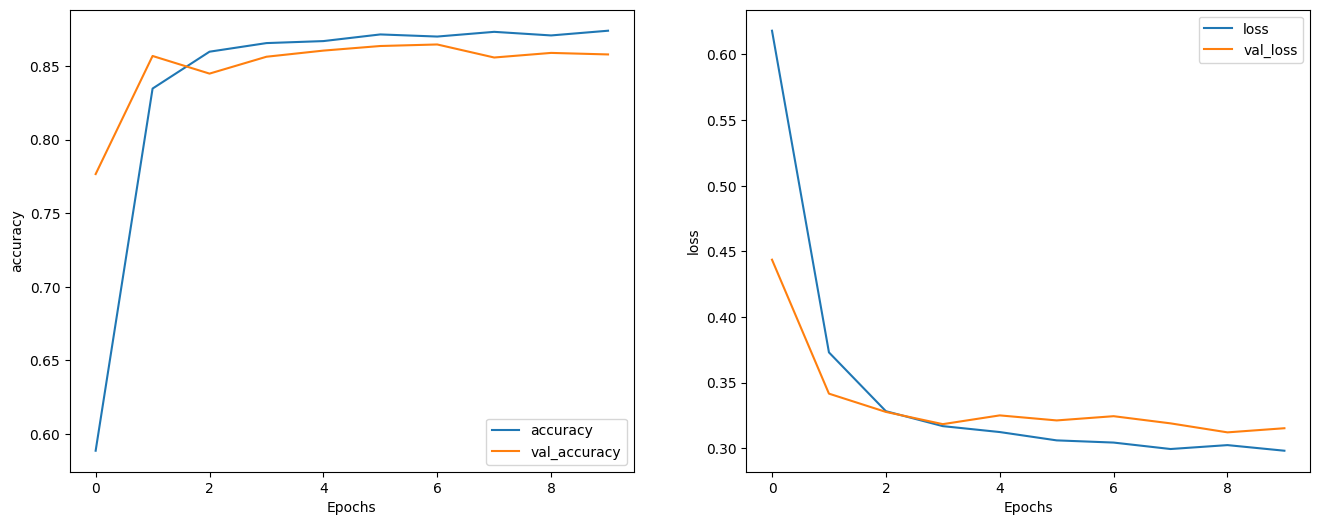

In [47]:
#cetak plot akurasi dan loss
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

***Keterangan***

1. Accuracy : akurasi model pada data pelatihan selama berjalannya epoch. Jika akurasi pelatihan terus meningkat seiring berjalannya epoch, itu menunjukkan bahwa model belajar dengan baik dari data pelatihan.

2. Val Accuracy : akurasi model pada data validasi yang merupakan data yang tidak digunakan dalam pelatihan. Jika akurasi validasi naik bersamaan dengan akurasi pelatihan, itu menunjukkan bahwa model dapat menggeneralisasi dengan baik ke data yang belum pernah dilihat sebelumnya.

3. Loss: Nilai kehilangan model pada data pelatihan seiring berjalannya epoch. Jika nilai loss pelatihan terus menurun seiring dengan peningkatan jumlah epoch, itu menunjukkan bahwa model terus mempelajari data pelatihan.

4. Val Loss: Validation loss adalah nilai kehilangan model pada data validasi yang merupakan data yang tidak digunakan dalam pelatihan. Jika nilai validation loss juga menurun seiring dengan peningkatan epoch, itu menunjukkan bahwa model dapat melakukan generalisasi dengan baik pada data yang belum pernah dilihat sebelumnya.